<a href="https://colab.research.google.com/github/mohsina680/BuildablesDataScienceFellowship/blob/main/iris_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports and dataset load
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix
from sklearn.metrics.cluster import contingency_matrix
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.optimize import linear_sum_assignment

# Make plots display inline
%matplotlib inline

# Load iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
df = pd.DataFrame(X, columns=feature_names)
df['species'] = [iris.target_names[i] for i in y]

print('Dataset shape:', X.shape)
df.head()

Dataset shape: (150, 4)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


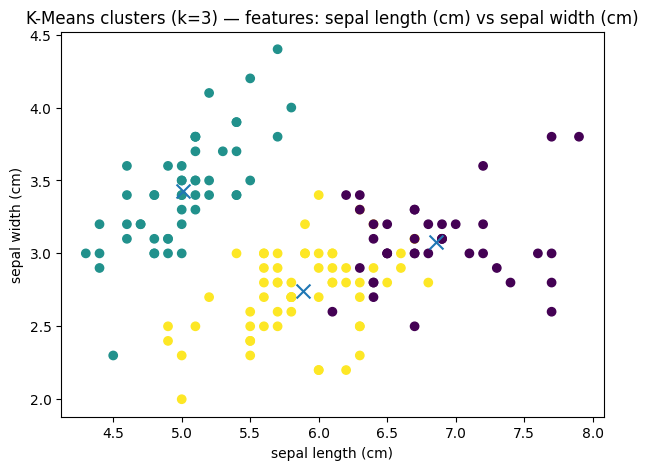

Adjusted Rand Index (KMeans vs true labels): 0.7163421126838476


In [ ]:
# Choose two features: sepal length (0) and sepal width (1)
feat_x = 0
feat_y = 1

kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
labels_km = kmeans.fit_predict(X)

# Scatter plot (two features)
plt.figure(figsize=(7,5))
plt.scatter(X[:, feat_x], X[:, feat_y], c=labels_km)
plt.scatter(kmeans.cluster_centers_[:, feat_x], kmeans.cluster_centers_[:, feat_y], marker='x', s=100)
plt.xlabel(feature_names[feat_x])
plt.ylabel(feature_names[feat_y])
plt.title('K-Means clusters (k=3) — features: {} vs {}'.format(feature_names[feat_x], feature_names[feat_y]))
plt.show()

# Compare to true labels (basic)
print('Adjusted Rand Index (KMeans vs true labels):', adjusted_rand_score(y, labels_km))

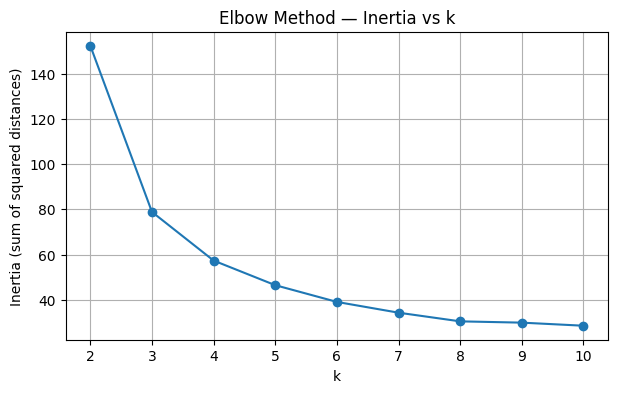

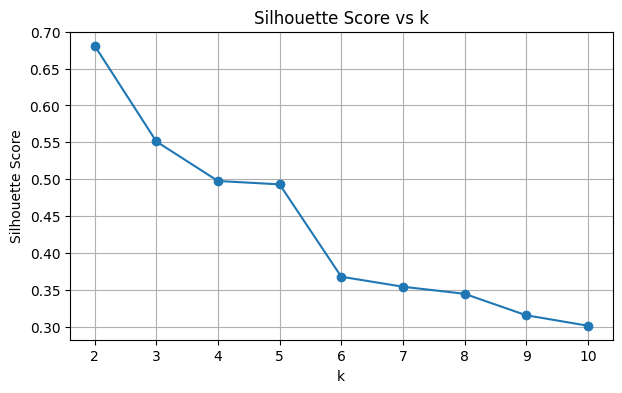

Silhouette scores by k:
k=2: silhouette=0.6810
k=3: silhouette=0.5512
k=4: silhouette=0.4976
k=5: silhouette=0.4931
k=6: silhouette=0.3678
k=7: silhouette=0.3543
k=8: silhouette=0.3447
k=9: silhouette=0.3156
k=10: silhouette=0.3014


In [ ]:
from sklearn.metrics import silhouette_samples

inertias = []
sil_scores = []
K_range = range(2,11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    lab = km.fit_predict(X)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X, lab))

# Plot inertia (Elbow)
plt.figure(figsize=(7,4))
plt.plot(list(K_range), inertias, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia (sum of squared distances)')
plt.title('Elbow Method — Inertia vs k')
plt.xticks(list(K_range))
plt.grid(True)
plt.show()

# Plot silhouette scores
plt.figure(figsize=(7,4))
plt.plot(list(K_range), sil_scores, marker='o')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs k')
plt.xticks(list(K_range))
plt.grid(True)
plt.show()

print('Silhouette scores by k:')
for k, s in zip(K_range, sil_scores):
    print(f'k={k}: silhouette={s:.4f}')

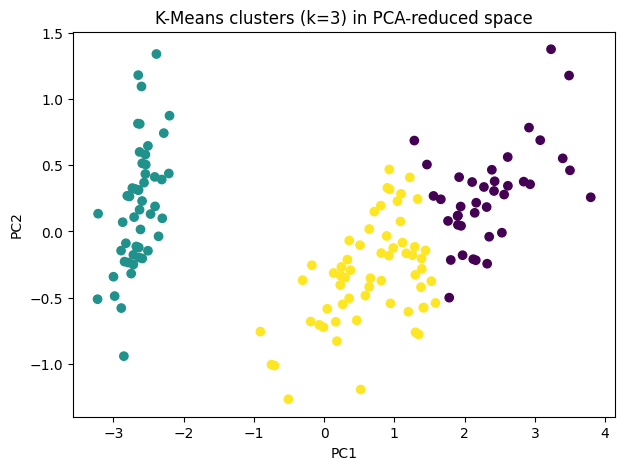

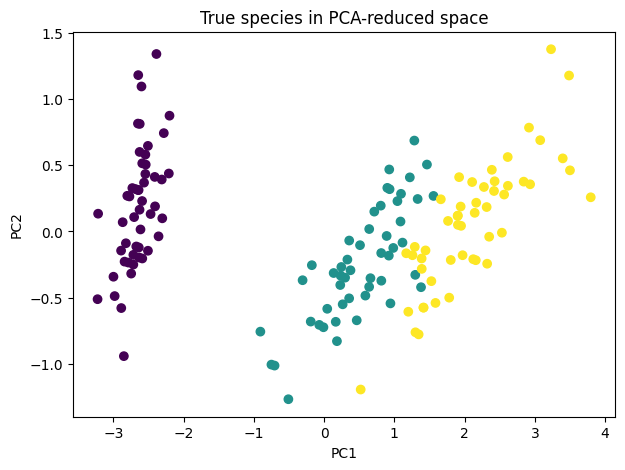

In [ ]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# KMeans on original data (k=3)
km3 = KMeans(n_clusters=3, random_state=42, n_init='auto')
labels_km3 = km3.fit_predict(X)

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_km3)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means clusters (k=3) in PCA-reduced space')
plt.show()

# Also plot true species in PCA space
plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('True species in PCA-reduced space')
plt.show()

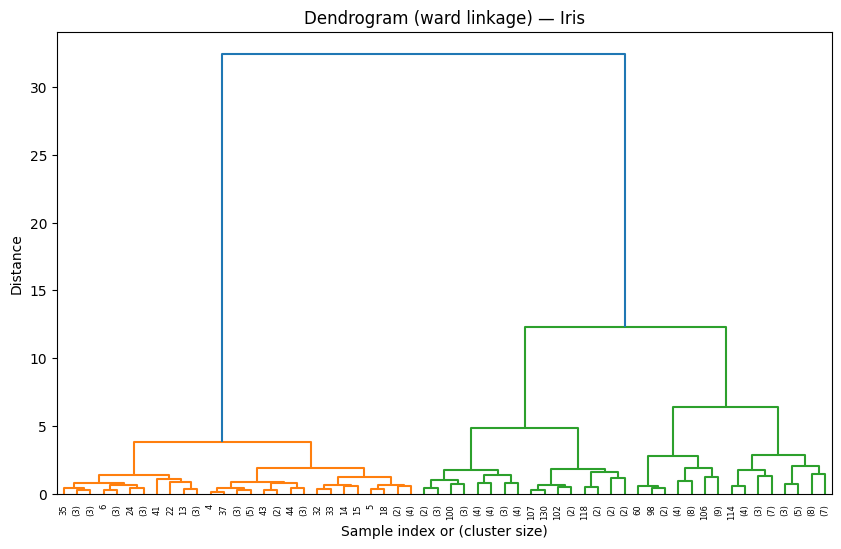

In [ ]:
# Compute linkage matrix (Ward's method)
Z = linkage(X, method='ward')

plt.figure(figsize=(10, 6))
dendrogram(Z, truncate_mode='level', p=5)
plt.title('Dendrogram (ward linkage) — Iris')
plt.xlabel('Sample index or (cluster size)')
plt.ylabel('Distance')
plt.show()

In [ ]:
# Fit Agglomerative (k=3)
agg = AgglomerativeClustering(n_clusters=3)
labels_agg = agg.fit_predict(X)

# Evaluation metrics
ari_km = adjusted_rand_score(y, labels_km3)
ari_agg = adjusted_rand_score(y, labels_agg)
sil_km = silhouette_score(X, labels_km3)
sil_agg = silhouette_score(X, labels_agg)

print('Adjusted Rand Index: KMeans = {:.4f}, Agglomerative = {:.4f}'.format(ari_km, ari_agg))
print('Silhouette Score: KMeans = {:.4f}, Agglomerative = {:.4f}'.format(sil_km, sil_agg))

# Helper to map cluster labels to true labels for comparison using Hungarian algorithm
def map_clusters_to_labels(true_labels, cluster_labels):
    cm = contingency_matrix(true_labels, cluster_labels)
    # row = true label, col = cluster label
    # maximize matching — linear_sum assigns minimum, so use negative
    row_ind, col_ind = linear_sum_assignment(-cm)
    mapping = {col:row for row, col in zip(row_ind, col_ind)}
    # create mapped cluster labels to predicted species indices
    mapped = [mapping[c] for c in cluster_labels]
    return np.array(mapped), cm, mapping

mapped_km, cm_km, mapping_km = map_clusters_to_labels(y, labels_km3)
mapped_agg, cm_agg, mapping_agg = map_clusters_to_labels(y, labels_agg)

print('\nContingency matrix (true labels rows x KMeans cluster cols):\n', cm_km)
print('Mapping KMeans cluster -> true label index:', mapping_km)

print('\nContingency matrix (true labels rows x Agglomerative cluster cols):\n', cm_agg)
print('Mapping Agglomerative cluster -> true label index:', mapping_agg)

# Show confusion matrices after mapping
print('\nConfusion matrix (KMeans mapped to species):')
print(confusion_matrix(y, mapped_km))
print('\nConfusion matrix (Agglomerative mapped to species):')
print(confusion_matrix(y, mapped_agg))

Adjusted Rand Index: KMeans = 0.7163, Agglomerative = 0.7312
Silhouette Score: KMeans = 0.5512, Agglomerative = 0.5543

Contingency matrix (true labels rows x KMeans cluster cols):
 [[ 0 50  0]
 [ 3  0 47]
 [36  0 14]]
Mapping KMeans cluster -> true label index: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(0): np.int64(2)}

Contingency matrix (true labels rows x Agglomerative cluster cols):
 [[ 0 50  0]
 [49  0  1]
 [15  0 35]]
Mapping Agglomerative cluster -> true label index: {np.int64(1): np.int64(0), np.int64(0): np.int64(1), np.int64(2): np.int64(2)}

Confusion matrix (KMeans mapped to species):
[[50  0  0]
 [ 0 47  3]
 [ 0 14 36]]

Confusion matrix (Agglomerative mapped to species):
[[50  0  0]
 [ 0 49  1]
 [ 0 15 35]]
